In [25]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import least_squares, fsolve

In [26]:
R = 8.3144626 #J/mol-K
F = 96485.33212 #C/mol

# import parameters from fitting data
%store -r air_params
%store -r zn_params

# Air electrode = cathode
O2 + 2H20 +4e- = 2OH-
# Zn electrode = anode
Zn + 4OH- = Zn(OH)4^2- +2e-

### Butler Volmer equations to describe kinetics
    i_0 = exchange current density - the value of the current density at equilibrium
    alpha_a = anodic charge transfer coefficient
    alpha_c = cathodic charge transfer coefficient
    alpha_a + alpha_c = number of electrons transferred in reaction
    eta = surface overpotential = potential - equilibrium potential

In [27]:
# General Butler-Volmer equation
def bv_eq(i_0, alpha_a, alpha_c, eta):
    R = 8.3144626
    T = 273 #K
    i = i_0*(np.exp((alpha_a*F*eta)/(R*T)) - np.exp((-alpha_c*F*eta)/(R*T)))
    return i

In [28]:
# Implement one version of BV equation for each reaction
# Model parameters for oxidation reduction reaction at air electrode

i_0_air = air_params[0] #A/m2
alpha_a_air = air_params[1] #unitless
alpha_c_air = air_params[2] #unitless


# Model parameters for zinc to zincate reaction at air electrode
i_0_zn = zn_params[0] #A 
alpha_a_zn = zn_params[1] #good approximation 0.5*4 electrons #unitless
alpha_c_zn = zn_params[2] #good approximation 0.5*4 electrons #unitless

# Equilibrium Potential
U_air = 0.55416954 #V - from experiment
U_zn = -0.62327188 #V - from experiment
U_cell = U_air - U_zn #V doublecheck - also should be pos or neg?

def current(X, *data):
    eta_air, eta_zn = X
    z = 2
    i_0_air, alpha_a_air, alpha_c_air, i_0_zn, alpha_a_zn, alpha_c_zn, R, T, U_cell, P = data
    i_air = i_0_air*(np.exp((z*alpha_a_air*F*eta_air)/(R*T)) - np.exp((-alpha_c_air*z*F*eta_air)/(R*T)))
    i_zn = i_0_zn*(np.exp((alpha_a_zn*z*F*eta_zn)/(R*T)) - np.exp((-alpha_c_zn*z*F*eta_zn)/(R*T)))
    
    V_cell = U_cell - eta_air - eta_zn
    
    return [i_air - i_zn, P - i_air*V_cell]


T = 293 #K
P = 1 #W - for now
A = 5 #m2
z = 2
data = (i_0_air, alpha_a_air, alpha_c_air, i_0_zn, alpha_a_zn, alpha_c_zn, R, T, U_cell, P)
eta_air_0, eta_zn_0, A_0 = 0, 0, 0
guess = [eta_air_0, eta_zn_0]
sol = fsolve(current, guess, args=data)
print(sol)
eta_air_calc = sol[0]
eta_zn_calc = sol[1]
i_air = i_0_air*(np.exp((alpha_a_air*z*F*eta_air_calc)/(R*T)) - np.exp((-alpha_c_air*z*F*eta_air_calc)/(R*T)))
i_zn = i_0_zn*(np.exp((alpha_a_zn*z*F*eta_zn_calc)/(R*T)) - np.exp((-alpha_c_zn*z*F*eta_zn_calc)/(R*T)))
print(i_air)
print(i_zn)


[ 0.49531063 -0.06603417]
1.3366036141442847
1.3366036141429438


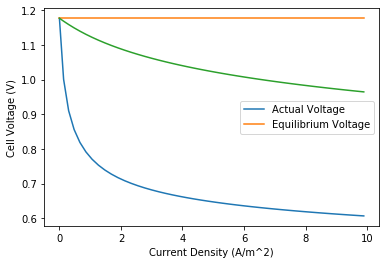

In [50]:
current_densities = []
voltages = []
power = []
eqvoltage = []
volt_minus_eta_air = []
power_densities = np.linspace(0,6,45)

for P in power_densities:
    #print('Power density =',P)
    data = (i_0_air, alpha_a_air, alpha_c_air, i_0_zn, alpha_a_zn, alpha_c_zn, R, T, U_cell, P)
    sol = fsolve(current, guess, args=data)
    #print('solution =', sol)
    eta_air_calc = sol[0]
    eta_zn_calc = sol[1]
    i_air = i_0_air*(np.exp((alpha_a_air*z*F*eta_air_calc)/(R*T)) - np.exp((-alpha_c_air*z*F*eta_air_calc)/(R*T)))
    current_densities.append(i_air)
    V_cell = U_cell - eta_air_calc - eta_zn_calc
    voltages.append(V_cell)
    volt_minus_eta_air.append(U_cell + eta_zn_calc)
    #print('current density =', i_air)
    #print('voltage =', V_cell)
    #try area of 1
    A=1
    power.append(V_cell*A*i_air)
    eqvoltage.append(U_cell)

    
#fig, ax1 = plt.subplots()

#ax2 = ax1.twinx()
plt.plot(current_densities, voltages, label='Actual Voltage')
plt.plot(current_densities, eqvoltage, label='Equilibrium Voltage')
plt.plot(current_densities, volt_minus_eta_air)
#ax2.plot(current_densities, power)
#np.ones_like(current_densities)*U_cell

plt.xlabel('Current Density (A/m^2)')
plt.ylabel('Cell Voltage (V)')
plt.legend()
#ax2.set_ylabel('Power (W)')    

plt.savefig('./poster/current_vs_voltage.png',dpi=500)
#plt.plot(current_densities, voltages)
#plt.plot(current_densities, power)
#plt.ylabel('Cell Voltage (V)')
#plt.xlabel('Current Density (A/m^2)')